## Report
---
This page describes choices and details results. It includes
- Description of the **model architectures** 
- Description of the **hyperparameters**
- Plot of **rewards**
- Ideas for **future works**

>Note1: for this project, I **did not need (and use) GPU** at all

>Note2: I spent around **25 hours** working on the project

### Description of the model architectures 
The repository is structured as follow.
- [`main_banana.ipynb`](src_submission/main_banana.ipynb) is *the central file*. It contains
    - all the import statements and instructions to start the environment
    - the calls to **train**
    - the calls to **test**
- [`dqn_agent_banana.py`](src_submission/dqn_agent_banana.py) defines two classes
    - **Agent** with methods such as step, act, learn 
    - **ReplayBuffer** to store experience tuples 
- [`model_banana.py`](src_submission/model_banana.py) defines the Q-Network used by the Agent as a function approximation for Q-values
- [`checkpoint380.pth`](src_submission/checkpoint380.pth) are the saved model weights of the most successful agent

Since the state space is relatively small (compared to 84 * 84 RGB pixels image e.g.), there is no need to implement convolutional layers. Multiple **fully-connected units** show good results.

The chosen architecture of the Q-network is composed of
    - State (space size = 37)
    - Fully-connected layer with *64* outputs
    - *ReLu* activation function
    - Fully-connected layer with *64* outputs
    - *ReLu* activation function
    - Fully-connected layer with *4* outputs (= action space size)

The Replay Memory
    - is based on *uniform sampling*

A **vanilla DQN** is used

    - no dueling structure
    - no double-DQN

For stability, a **soft update** of the model parameters is completed.
    - `θ_target = τ*θ_local + (1 - τ)*θ_target`

This is done in the static method `soft_update(local_model, target_model, tau)` where the models to update are passed by reference.

### Description of the hyperparameters


In [21]:
# hyperparameters
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
# Network architecture
fc1_units = 64
fc2_units = 64
# Epsilon scheduling
eps_decay = 0.935
nb_episodes = 1500
eps_end = 0.01
eps_start = 1.0

#### Epsilon scheduling
This is one **important hyperparameter** I play with.

I implemented an **epsilon decay** scheduling:

- `eps = max(eps_end, eps_decay * eps)`

To better understand how this commonly used technique works, I **plot** the epsilon scheduling and compare it to a **linear strategy**

---

Values used:
- Initially, I used `eps_decay = 0.995`.

    - Nevertheless, I observed that for this setting, `eps_start * eps_decay ** i == eps_end` is realized for the first time at `i=ln(eps_end)/ln(eps_decay) =` **918 episodes**

    - And, when solving the problem after **380 episodes**, **epsilon is still high** (~0.15)

- A **faster decay** can therefore be tried
    - I target to reach the constant plateau of `eps_end` at **300 episodes**
    - Hence `eps_decay = 0.985 = eps_end ** (1/300)`

- This shows a **significant improvement**
    - from an average of 420 episodes, it reduces to an **average of 130 episodes**.

- I decide to go further and look for an **even faster decay** can therefore be tried
    - I target to reach the constant plateau of `eps_end` at **130 episodes**
    - Hence `eps_decay = 0.935 = eps_end ** (1/130)`

- This shows also a **large improvement**
    - from an average of 130 episodes, it reduces to an **average of 55 episodes**.

- I keep going and try `eps_decay = 0.92` to get to the plateau after 50 episodes
- Again, **great improvement**
    - from an average of 55 episodes, it reduces to an **average of 2 episodes**.

> Ok, `2` means that the `mean{return} over [episode_2 ... episode_102]` is larger than `13` 

- yet it is not as stable, compared to slower decay. It yield an average in results of `95 episodes` with subsequent tests

|eps_decay| 0.995| 0.985|0.935|0.92|
|---|---|---|---|---|---|
|Episodes needed (average)| 430 | 130 |55 | 95 |
  

> Conclusion1: the **hyperparameter epsilon_decay** seems to play a **significiant role**

> Conclusion2: the setting `eps_deacy = 0.935` looks the better in term of **performance with stability**
  
Future work could include
- the *refinement* of the *optimization*
- the measure and tests of *other schedulings*

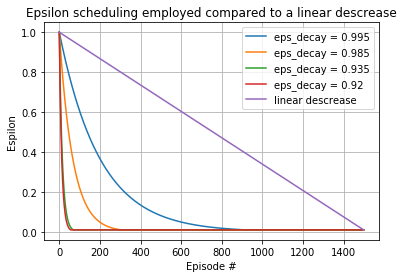

In [22]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
eps_decay = 0.995  # leads to best result = 380
eps_decay2 = 0.985  # leads to best result = 130
eps_decay3 = 0.935  # lead to best result = 51
eps_decay4 = 0.92  # lead to best result = 2 but no stable

nb_episodes = 1500
eps_end = 0.01
eps_start = 1.0
eps = [max(eps_start * eps_decay ** i, eps_end) for i in range(nb_episodes)]
eps2 = [max(eps_start * eps_decay2 ** i, eps_end) for i in range(nb_episodes)]
eps3 = [max(eps_start * eps_decay3 ** i, eps_end) for i in range(nb_episodes)]
eps4 = [max(eps_start * eps_decay4 ** i, eps_end) for i in range(nb_episodes)]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(eps)), eps, label='eps_decay = 0.995')
plt.plot(np.arange(len(eps2)), eps2, label='eps_decay = 0.985')
plt.plot(np.arange(len(eps3)), eps3, label='eps_decay = 0.935')
plt.plot(np.arange(len(eps4)), eps4, label='eps_decay = 0.92')
plt.plot(np.arange(len(eps)), np.linspace(eps_start, eps_end, len(eps)), label='linear descrease')
plt.ylabel('Espilon')
plt.xlabel('Episode #')
plt.grid()
plt.title("Epsilon scheduling employed compared to a linear descrease")
ax.legend()
plt.show()

After looking at the **epsilon scheduling**, I investigate the **impact** of **two additionnal hyper-parameters**:

#### Discount Factor
- I test 7 values, all other parameters being unchanged

- `gamma_pool = [1, 0.99, 0.95, 0.8, 0.5, 0.3, 0]`

- Results are summurized in this table.


|Discount factor|1| 0.99| 0.95| 0.8| 0.5| 0.3| 0|
|---|---|---|---|---|---|---|---|
|Episodes needed|  451 [+/- 39]|  430 [+/- 30] | N.A.  | N.A  |  N.A. |  N.A. |  N.A. |
  
- `N.A.` means that *5000 episodes were not enough* to solve the problem, i.e. the value of discount rate does not allow for a solution

- Note: the value `eps_decay = 0.995` was used

- Conclusion: the environment requires a **long-term strategy** for planning. Hence the discout rate should be high, just slightly lower than 1. Yet not exactly equal to 1 to avoid freezing issue.

> The **value** of `gamma=0.99` seems **relevant** 



#### Depth of the Q-network
The **depth** of the Q-network, i.e. the number of hidden layers, is also investigated

- Note: the value `eps_decay = 0.995` was used

- Architectures of 1, 2 and 3 FC layers are compared 
    
|layers|1| 2| 3|
|---|---|---|---|
|Episodes needed|  468 |  430 | 470  |
|Time needed (min)|  10.1 | 10.4  |  12.5 |

   - Conclusion: stacking layers stops showing relevance after 2 FC layers. The **2-FC-layer** structure gives the best results. One could go for a **shadow structure** since it offer performance not far from the top while **limiting the complexity** and hence the time required.

> To achieve the best performance, the **2-FC-layer** structure is adapted

- Compared to the `eps_decay` parameter, the **depth of the network** does not play a significant role

#### Significativity
I conducted **10 experiences** with the **parameteres and seed hold fixed** to appreciate the **variations** in the results.

The findings are presented in the following scatter plot:

422.40 = mean nb of episodes to success
32.71 = std nb of episodes to success


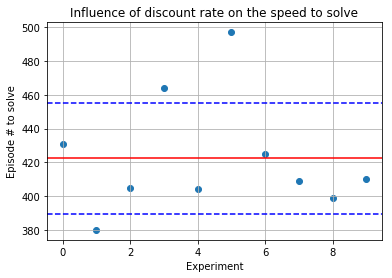

In [20]:
episodes = [431, 380,  405, 464, 404, 497, 425, 409, 399, 410]
mean = np.mean(episodes)
print("{0:.2f} = mean nb of episodes to success".format(mean))
std = np.std(episodes)
print("{0:.2f} = std nb of episodes to success".format(std))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(np.arange(len(episodes)), episodes)
plt.axhline(y=mean, color='r', linestyle='-')
plt.axhline(y=mean+std, color='b', linestyle='--')
plt.axhline(y=mean-std, color='b', linestyle='--')
plt.xlabel('Experiment')
plt.ylabel('Episode # to solve')
plt.grid()
plt.title("Influence of discount rate on the speed to solve")
plt.show()

> Conclusion: It is important to **repeat the experiment** to **validate of the first observations**

### Plot of Rewards

During training, every **return** (=sum of collected rewards) is saved. At the end, a plot shows their evolution.

| ![caption](report_submission/2.svg) | 
|:--:| 
| *Rewards for each episode - here one of the best outcomes: "Environment solved in 2 episodes"* |

### Ideas for Future Work

To improve the agent's performance

- given that *performance* is measured with the **average** number of episodes needed to solve the environment, regardless of the computational cost, it is important to **reduce the standard deviation** of the results.
- I noticed that agent that works well on 1 or 2 tests can then bug, freeze and start **"tilting"**, i.e. going into a **succession of Left/Right** from where it never escapes.
- I also detected this with the **distribution of actions**: 	 `action: Counter({2: 151, 3: 149})`
- It clearly impact the average performance. On solution could be to **include the previous (or more) action into the state** and account for the **change in action** into the **reward function**
- Another to applied **Q-Mask** or **Shield** to prevent some actions to be taken, based on hand writen-rules such as: _"if transitioned twice Left-Right, prevent one of the two action for 5 steps"_.
- This should deblock the agent.

Other ideas:
- I am implementing a PER (**Prioritized Experience Replay**).

    - At the time of submission, I am not able to report any results.
    - For sure it is worth trying this technique to improve performance and robustness.

- Dueling and Double-DQN should be investigated as well to increase the **stability in learning**



--- 
To makes the task more challenging:

- One could try to modify the environment, especially to add **different colours** with **different rewards**
    -  this [link](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Getting-Started-with-Balance-Ball.md) shows how to build Unity environments
    
- It would be interesting to add a **energy-constraint** on the agent in the form of a **limited battery life**.
    - the goal would be to collect bananas while **taking care not to run out of energy**
    - one or **multiple loading stations** could be placed in the environment
    - when running low, the decision would be to **stop chasing bananas** to go refueling the battery
    - the following diagramm show an example of such **meta-policy**
    - a **hierarchical strategy** could be implemented.
    - approaches such as thoses described [here](https://www.oreilly.com/ideas/reinforcement-learning-for-complex-goals-using-tensorflow) for **“direct future prediction” (DFP)** also looks promizing.

| ![caption](https://cdn-images-1.medium.com/max/1600/1*EmYiXaxLGxvLXFSquBFGrQ.png) | 
|:--:| 
| *Possible states of the robot, transitional probabilities and respective rewards. (Source: Udacity)* |